# CBM 분석 모델 Function 정리

## 데이터 전처리

In [1]:
# 
# =============== Bearing Interporlation ==============
# parameter : 
#                df: Data Frame
#           
# Result : 
#         column의 전후 값 평균으로 값을 채워줌       
#                
#================================================
import pandas as pd 
import numpy as np 
import sys 
import os 
df = pd.read_csv('bearing_1.csv')
def bearing_interporlation (df): 
    col_names = list(df.columns)[2:] # excep date and time 
    for col_name in col_names: 
        temp_col = df[col_name]
        is_NAN = temp_col.isnull()
        total_missing = np.sum(is_NAN)
        if total_missing>0: 
            NAN_index = list(np.where(is_NAN==True)[0])
            for index in NAN_index: 
                if index == 0: 
                    avg_missing = df[col_name][index+1]
                elif index == len(temp_col)-1: 
                    avg_missing = df[col_name][index-1]
                else: 
                    upper_index = index-1
                    lower_index = index+1 
                    avg_missing = np.mean(temp_col[upper_index]+temp_col[lower_index])
                df[col_name][index] = avg_missing
        
    return df 

In [5]:
interpolated_df = bearing_interporlation (df)
print(interpolated_df.isnull().sum())

Date                       0
Time                       0
P1(Overall RMS (g))        0
P2(Shaft 1X (g))           0
P3(Shaft 2X (g))           0
P4(KTM Band (g))           0
P5(BPFI (g))               0
P6(BPFO (g))               0
P7(BSF (g))                0
P8(FTF (g))                0
P9(Crest Factor (none))    0
P10(Demodulation (g))      0
P12(RPM (RPM))             0
P13(Train Speed (km/h))    0
RPM                        0
Overall                    0
1X                         0
2X                         0
Crest factor               0
dtype: int64


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_2696\1393451298.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col_name][index] = avg_missing


In [3]:

# =============== Moving Average ==============
# parameter : 
#                df: Data Frame
#                T: moving range, should be odd number
# Result : 
#         column의 전후 T 개의 값 평균으로 값을 채워줌         
#                
#================================================

def bearing_moving_avg(df,T): # T: moving range, should be odd number
    df.fillna(0) # assign all mission variables to 0 
    col_names = list(df.columns)[2:] # excep date and time 
    total_list = []
    for col_name in col_names: 
        temp_col_list = [] 
        temp_col = df[col_name]

        list_range = list(range(T//2, len(temp_col)-T//2-1))

        for index in range(len(temp_col)):
            if index not in list_range:  
                value = temp_col[index]
                temp_col_list.append(value)
            else: 
                upper_index = index-T//2
                lower_index = index+T//2+1
                moving_average = np.mean(temp_col[upper_index:lower_index])
                temp_col_list.append(moving_average)
        total_list.append(temp_col_list)

    new_df = pd.DataFrame(total_list).T
    new_df.columns = list(df.columns)[2:] # excep date and time 
    new_df.insert(0,'Date',df['Date'])
    new_df.insert(1,'Time',df['Time'])
    return new_df

In [6]:
df = pd.read_csv('bearing_1.csv')
T = 5
moving_averaged_df = bearing_moving_avg (df,T)
print(moving_averaged_df.isnull().sum())

Date                       0
Time                       0
P1(Overall RMS (g))        1
P2(Shaft 1X (g))           0
P3(Shaft 2X (g))           0
P4(KTM Band (g))           0
P5(BPFI (g))               0
P6(BPFO (g))               0
P7(BSF (g))                0
P8(FTF (g))                0
P9(Crest Factor (none))    0
P10(Demodulation (g))      0
P12(RPM (RPM))             0
P13(Train Speed (km/h))    1
RPM                        0
Overall                    0
1X                         0
2X                         0
Crest factor               0
dtype: int64


## FFT (고속 프리에 변환) --call_FFT(df, col_name, win_size)

In [7]:
import matplotlib.pyplot as plt
plt.style.use('default')
import pandas as pd
import numpy  as np
from safeeye_prepro import call_FFT, call_moving_average, call_variance, call_histogram

In [10]:
df = moving_averaged_df

,Date,Time,P1(Overall RMS (g)),P2(Shaft 1X (g)),P3(Shaft 2X (g)),P4(KTM Band (g)),P5(BPFI (g)),P6(BPFO (g)),P7(BSF (g)),P8(FTF (g)),P9(Crest Factor (none)),P10(Demodulation (g)),P12(RPM (RPM)),P13(Train Speed (km/h)),RPM,Overall,1X,2X,Crest factor
0,2022.2.18,14:47:18,NaN,0.007540,0.007540,0.001148,0.007540,0.007540,0.007540,0.007540,1.712194,0.078452,0.000000,0.000000,66.20,0.2350,0.00100,0.00140,5.0420
1,2022.2.18,14:47:19,0.133108,0.011565,0.011565,0.001078,0.011565,0.011565,0.011565,0.011565,1.740452,0.090459,0.000000,0.000000,35.70,0.2240,0.00110,0.00090,5.9660
2,2022.2.18,14:47:20,0.126030,0.015759,0.015759,0.001086,0.015800,0.015761,0.015759,0.015759,1.661041,0.086227,1.652000,0.267799,41.80,0.4508,0.00216,0.00170,6.0098
3,2022.2.18,14:47:21,0.125882,0.018551,0.018551,0.001069,0.018594,0.018555,0.018551,0.018551,1.646475,0.088470,2.770000,0.449034,35.70,0.5716,0.00376,0.00194,6.0446
4,2022.2.18,14:47:22,0.126232,0.018036,0.018036,0.001063,0.018087,0.018047,0.018044,0.018036,1.638901,0.088766,4.162000,0.674686,103.16,0.6936,0.00410,0.00376,6.3088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,2022.2.18,14:48:46,0.159157,0.006330,0.006380,0.004192,0.001974,0.001379,0.000639,0.006275,4.677123,0.117405,98.957999,15.960569,631.00,0.7118,0.00510,0.00580,6.2654
87,2022.2.18,14:48:47,0.163839,0.006922,0.006968,0.004052,0.002159,0.001460,0.000699,0.006873,4.631299,0.121920,100.021999,16.176171,631.00,0.6396,0.00446,0.00398,6.4572
88,2022.2.18,14:48:48,0.161215,0.003027,0.003049,0.003381,0.001565,0.001602,0.000627,0.002933,5.017599,0.119434,100.959999,NaN,631.00,0.5660,0.00370,0.00150,6.9720
89,2022.2.18,14:48:49,0.169403,0.006377,0.006429,0.003441,0.002660,0.001473,0.000866,0.006343,4.177364,0.127187,102.279999,16.580221,631.00,0.4940,0.00190,0.00190,6.8040


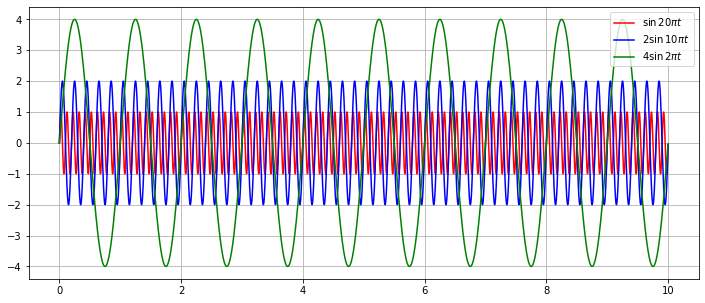

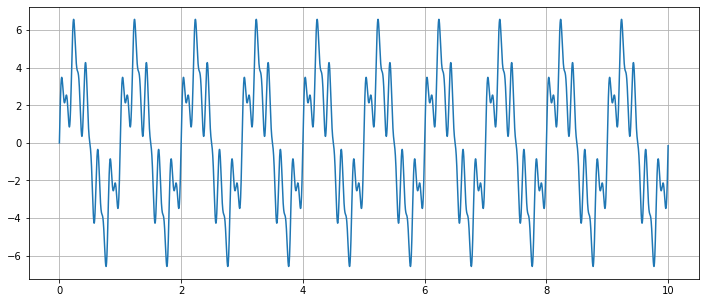

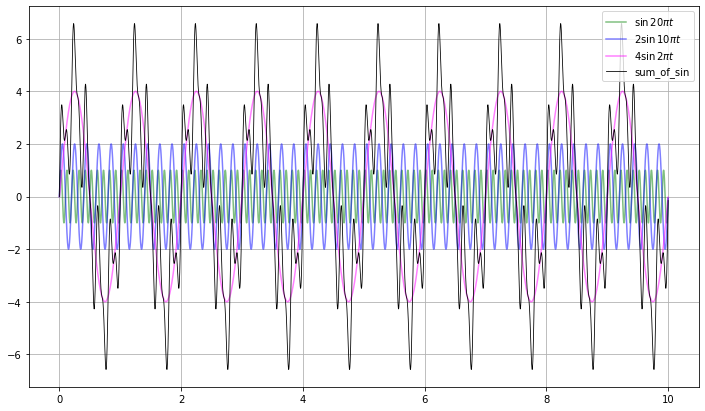

In [35]:
def sin_wave(amp, freq, time):
    return amp * np.sin(2*np.pi*freq*time)

#---------------------------------------------- 총 10초 길이의 10Hz(진폭=1), 5Hz(진폭=2), 1Hz(진폭=4) Sin 파형 생성
time = np.arange(0, 10, 0.001)
sin1 = sin_wave(1, 10, time)
sin2 = sin_wave(2, 5, time)
sin3 = sin_wave(4, 1, time)

#---------------------------------- Drawing.............
plt.figure(figsize=(12,5))
plt.plot(time, sin1, label=r"$\sin {20\pi} t$", color='red')
plt.plot(time, sin2, label=r"$2\sin {10\pi} t$", color='blue')
plt.plot(time, sin3, label=r"$4\sin {2\pi} t$", color='green')
plt.legend(); plt.grid(); plt.show()

#--------------------------------------------- 복합 신호 생성
sin_sum = sin1 + sin2 + sin3

plt.figure(figsize=(12,5))
plt.plot(time, sin_sum)
plt.grid()
plt.show()

#--------------------------------------------- 겹쳐서 그리기
plt.figure(figsize=(12,7))
plt.plot(time, sin1, label=r"$\sin {20\pi} t$", color='green', alpha=0.5)
plt.plot(time, sin2, label=r"$2\sin {10\pi} t$", color='blue', alpha=0.5)
plt.plot(time, sin3, label=r"$4\sin {2\pi} t$", color='magenta', alpha=0.5)
plt.plot(time, sin_sum, label="sum_of_sin", color='black', lw=0.8)
plt.legend(); plt.grid(); plt.show()

In [38]:
moving_averaged_df

,Date,Time,P1(Overall RMS (g)),P2(Shaft 1X (g)),P3(Shaft 2X (g)),P4(KTM Band (g)),P5(BPFI (g)),P6(BPFO (g)),P7(BSF (g)),P8(FTF (g)),P9(Crest Factor (none)),P10(Demodulation (g)),P12(RPM (RPM)),P13(Train Speed (km/h)),RPM,Overall,1X,2X,Crest factor
0,2022.2.18,14:47:18,NaN,0.007540,0.007540,0.001148,0.007540,0.007540,0.007540,0.007540,1.712194,0.078452,0.000000,0.000000,66.20,0.2350,0.00100,0.00140,5.0420
1,2022.2.18,14:47:19,0.133108,0.011565,0.011565,0.001078,0.011565,0.011565,0.011565,0.011565,1.740452,0.090459,0.000000,0.000000,35.70,0.2240,0.00110,0.00090,5.9660
2,2022.2.18,14:47:20,0.126030,0.015759,0.015759,0.001086,0.015800,0.015761,0.015759,0.015759,1.661041,0.086227,1.652000,0.267799,41.80,0.4508,0.00216,0.00170,6.0098
3,2022.2.18,14:47:21,0.125882,0.018551,0.018551,0.001069,0.018594,0.018555,0.018551,0.018551,1.646475,0.088470,2.770000,0.449034,35.70,0.5716,0.00376,0.00194,6.0446
4,2022.2.18,14:47:22,0.126232,0.018036,0.018036,0.001063,0.018087,0.018047,0.018044,0.018036,1.638901,0.088766,4.162000,0.674686,103.16,0.6936,0.00410,0.00376,6.3088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,2022.2.18,14:48:46,0.159157,0.006330,0.006380,0.004192,0.001974,0.001379,0.000639,0.006275,4.677123,0.117405,98.957999,15.960569,631.00,0.7118,0.00510,0.00580,6.2654
87,2022.2.18,14:48:47,0.163839,0.006922,0.006968,0.004052,0.002159,0.001460,0.000699,0.006873,4.631299,0.121920,100.021999,16.176171,631.00,0.6396,0.00446,0.00398,6.4572
88,2022.2.18,14:48:48,0.161215,0.003027,0.003049,0.003381,0.001565,0.001602,0.000627,0.002933,5.017599,0.119434,100.959999,NaN,631.00,0.5660,0.00370,0.00150,6.9720
89,2022.2.18,14:48:49,0.169403,0.006377,0.006429,0.003441,0.002660,0.001473,0.000866,0.006343,4.177364,0.127187,102.279999,16.580221,631.00,0.4940,0.00190,0.00190,6.8040


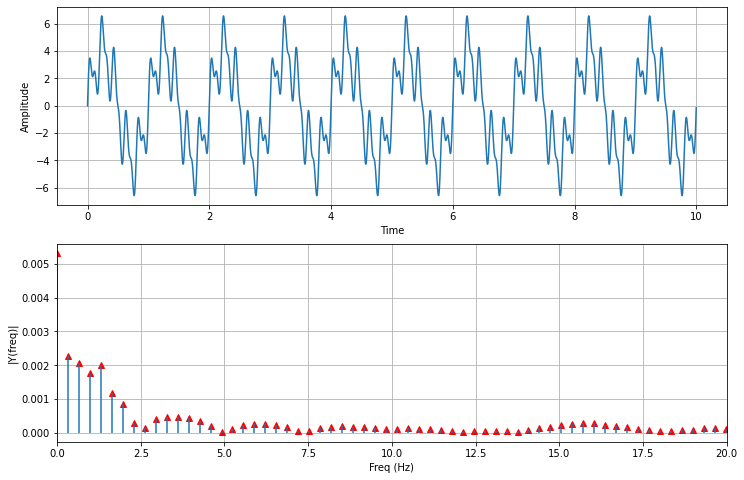

In [41]:
df =pd.read_csv('data/wheel_data_M1.csv', parse_dates=True) #  moving_averaged_df
#df = pd.DataFrame(sin_sum, columns=['Shaft_1X'])
spectrum, freq = call_FFT(df, 'Shaft_1X')  # ====================== FFT 함수 호출 예제 ============================

fig, ax = plt.subplots(2, 1, figsize=(12,8))
time = np.arange(0, 10, 0.001)
ax[0].plot(time, sin_sum)
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Amplitude'); 
ax[0].grid(True)

ax[1].plot(freq, abs(spectrum), 'r', linestyle=' ', marker='^') 
ax[1].set_xlabel('Freq (Hz)')
ax[1].set_ylabel('|Y(freq)|')
ax[1].vlines(freq, [0], spectrum)
ax[1].set_xlim([0, 20]); 
ax[1].grid(True)
plt.show()

## 이동 평균값 추청 -- call_moving_average

<AxesSubplot:xlabel='Date'>

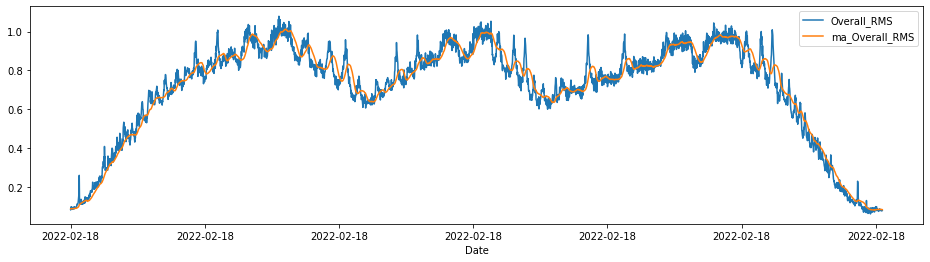

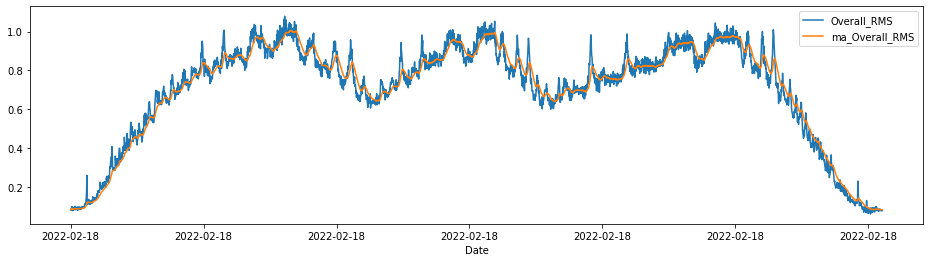

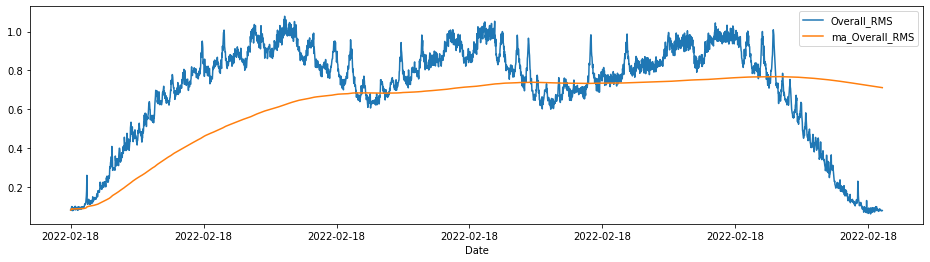

In [15]:
#---------------------------- Testing : Movinge Average ----------------------------
df_reliance = pd.read_csv('data/wheel_data_M1.csv', parse_dates=True)
#df_reliance = moving_averaged_df # moving_averaged_df # interpolated_df

df_reliance
df_ma = call_moving_average(df_reliance, 'Overall_RMS', 30, datetime_col='Date')
df_ma.set_index('Date', inplace=True)
# print (df_ma)
df_ma[['Overall_RMS', 'ma_Overall_RMS']].plot(label='Reliance', figsize=(16,4))

df_ma = call_moving_average(df_reliance, 'Overall_RMS', 30, datetime_col='Date', type_ma='ema')
df_ma.set_index('Date', inplace=True)
# print (df_ma)
df_ma[['Overall_RMS', 'ma_Overall_RMS']].plot(label='Reliance', figsize=(16,4))

df_ma = call_moving_average(df_reliance, 'Overall_RMS', 30, datetime_col='Date', type_ma='cma')
df_ma.set_index('Date', inplace=True)
# print (df_ma)
df_ma[['Overall_RMS', 'ma_Overall_RMS']].plot(label='Reliance', figsize=(16,4))

## 분산값 추정 -- call_variance

In [16]:
df = pd.read_csv('data/wheel_data_M1.csv', parse_dates=True)
df.set_index('Time', inplace=True)
df.drop(['Date'], axis='columns', inplace=True)
df_var = call_variance(df, ['Overall_RMS'])
df_var

Overall_RMS    0.064518
dtype: float64

<AxesSubplot:xlabel='Time'>

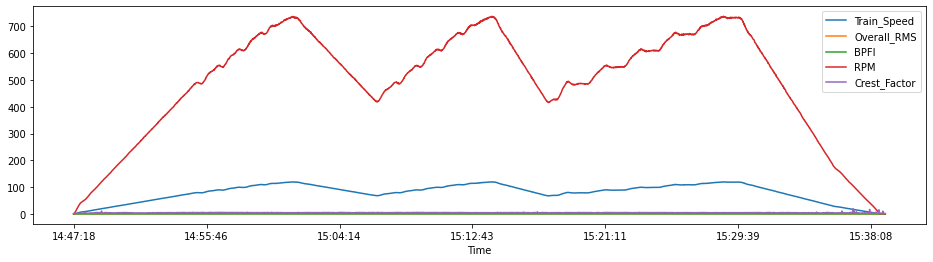

In [28]:
# df_var['Speed'] = df_var['Train_Speed'] / 100
#df_var['RPM'] = df_var['RPM'] / 100
#df_var['Crest_Factor'] = df_var['Train_Speed'] / 10
df[['Train_Speed', 'Overall_RMS','BPFI', 'RPM', 'Crest_Factor']].plot(label='RPM vs. Speed', figsize=(16,4))

## 히스토그램 산출 -- call_histogram

,bucket,count
0,0.114092,145
1,0.164852,89
2,0.215612,63
3,0.266371,37
4,0.317131,42
5,0.367891,46
6,0.418651,48
7,0.469411,54
8,0.520171,46
9,0.570931,51


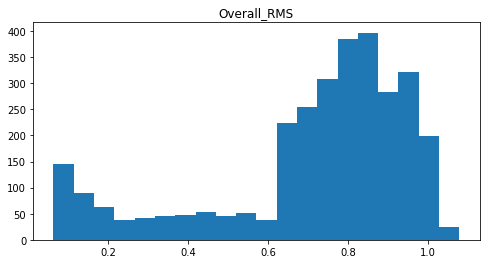

In [17]:
df = pd.read_csv('data/wheel_data_M1.csv', parse_dates=True)
df.set_index('Time', inplace=True)
df.drop(['Date'], axis='columns', inplace=True)
df_hist = call_histogram(df, ['Overall_RMS'], bins=20, figsize=(8,4)) #(16, 4))
df_hist

## CorrelationMatrix 산출 , normalization 

In [29]:
#------------------------------------------------------------------------------------------------
def getCorrelationMatrix(df, f_draw=True) :  #--------- Dataframe의 Correlation Matrix 구하기
#------------------------------------------------------------------------------------------------
    import seaborn as sns
    df_corr = df.corr()
    if not f_draw :
        return df_corr

    fig, ax = plt.subplots( figsize=(7,7) )

    # 삼각형 마스크를 만든다(위 쪽 삼각형에 True, 아래 삼각형에 False)
    mask = np.zeros_like(df_corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # 히트맵을 그린다
    sns.heatmap(df_corr, 
                cmap = 'RdYlBu_r', 
                annot = True,   # 실제 값을 표시한다
                mask=mask,      # 표시하지 않을 마스크 부분을 지정한다
                linewidths=.5,  # 경계면 실선으로 구분하기
                cbar_kws={"shrink": .5},# 컬러바 크기 절반으로 줄이기
                vmin = -1,vmax = 1   # 컬러바 범위 -1 ~ 1
               )  
    plt.show()
    return df_corr


#------------------------------------------------------------------------------------------------
def normalizeDataframe(df, scaling='Z-Score') :   #---  Data Normalization : 3 Selectable Methods
#------------------------------------------------------------------------------------------------
    if scaling=='Z-Score' :
        from sklearn.preprocessing import StandardScaler
        scaler = StandardScaler()
        

    if scaling=='MinMax' :
        from sklearn.preprocessing import MinMaxScaler
        scaler = MinMaxScaler()

    if scaling=='MaxAbs' :
        from sklearn.preprocessing import MaxAbsScaler
        scaler = MaxAbsScaler()
        
    scaler.fit(df)
    scaled = scaler.fit_transform(df)
    scaled_df = pd.DataFrame(scaled, columns=df.columns)
    return scaled_df

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_2696\2167055741.py:12: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(df_corr, dtype=np.bool)


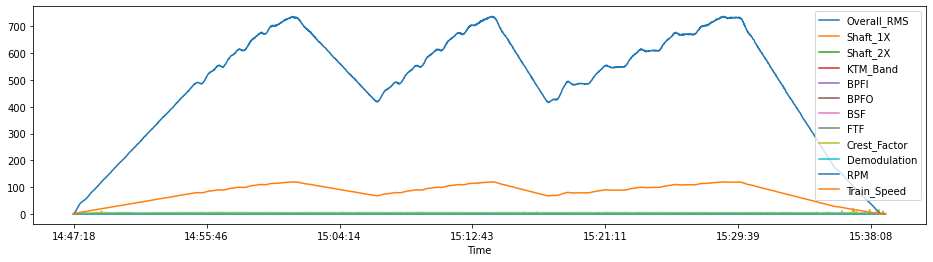

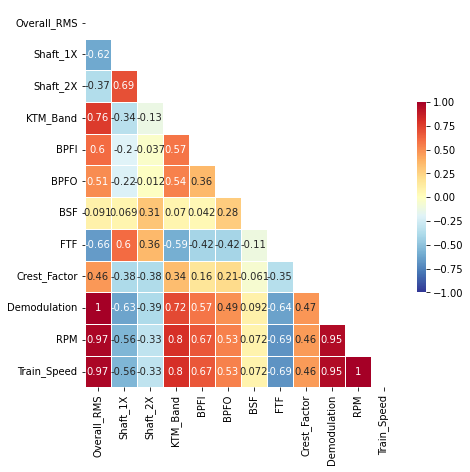

In [30]:
df_var = pd.read_csv('data/wheel_data_M1.csv', parse_dates=True)
df_var.set_index('Time', inplace=True)

df_var.plot(label='M1 Wheel Sensor Data', figsize=(16,4))

df_corr = getCorrelationMatrix(df_var, f_draw=True)

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_2696\2167055741.py:12: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(df_corr, dtype=np.bool)


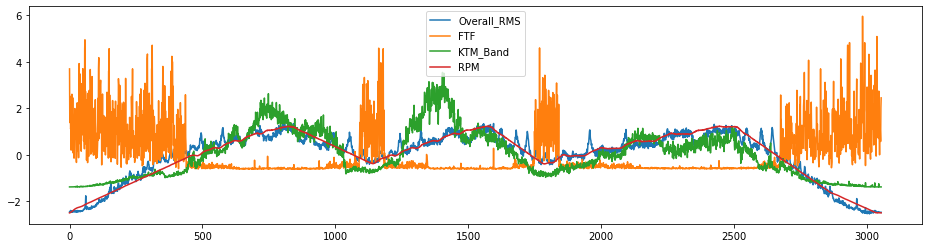

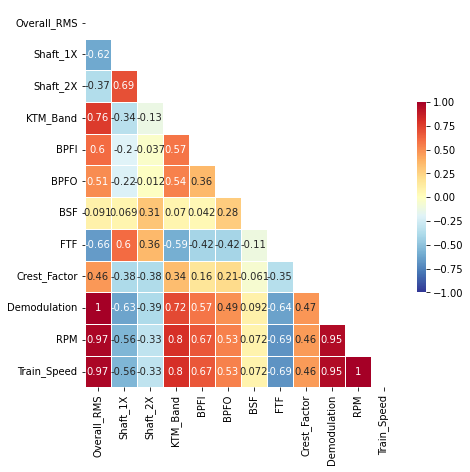

In [31]:
df_var.dropna(inplace=True)
df = df_var.drop(['Date'], axis='columns')

df_scaled = normalizeDataframe(df, scaling='Z-Score') # MaxAbs') # MinMax') # Z-Score')
df_scaled[['Overall_RMS', 'FTF', 'KTM_Band', 'RPM']].plot(label='M1 Wheel Sensor Data', figsize=(16,4))

df_s_corr = getCorrelationMatrix(df_scaled, f_draw=True)
